# PCA(주성분 분석)

PCA(Principal Component Analysis)는 주성분 분석으로, 데이터의 차원을 축소하는 통계적 기법이다. 고차원의 데이터를 저차원으로 변환하여 데이터의 중요한 구조를 유지하면서도 분석을 용이하게 한다. PCA는 데이터의 분산을 최대화하는 방향으로 새로운 축(주성분)을 찾아낸다.

PCA의 기본 절차는 다음과 같다:

1. 데이터 정규화: 데이터의 각 특성(feature)을 평균이 0이고 분산이 1인 값으로 표준화한다.

2. 공분산 행렬 계산: 표준화된 데이터의 공분산 행렬을 계산한다. 이 행렬은 데이터의 특성들 간의 상관관계를 나타낸다.

3. 고유값 분해: 공분산 행렬의 고유값(eigenvalue)과 고유벡터(eigenvector)를 계산한다. 고유벡터는 주성분을 나타내며, 고유값은 그 주성분의 중요도를 나타낸다.

4. 주성분 선택: 고유값이 큰 순서대로 몇 개의 주성분을 선택한다. 선택된 주성분의 개수는 변환 후 데이터의 차원 수를 결정한다.

5. 데이터 변환: 원 데이터를 선택된 주성분으로 변환하여 새로운 저차원 데이터를 얻는다.

In [8]:
import requests
import io
import numpy as np

url = 'https://bit.ly/fruits_300_data'
response = requests.get(url)
fruits = np.load(io.BytesIO(response.content))
fruits_2d = fruits.reshape(-1,100*100)

In [10]:
from sklearn.decomposition import PCA

# n_components는 주성분의 개수를 미미
pca = PCA(n_components=50)
pca.fit(fruits_2d)

PCA(n_components=50)

In [12]:
print(pca.components_.shape)

(50, 10000)


주성분의 개수 = 50개, 원본 데이터의 특성 개수 = 10000개

In [23]:
import matplotlib.pyplot as plt

def draw_fruits(arr, ratio = 1):
    n = len(arr)

    #한줄에 10개씩 이미지 생성. 샘플개수를 10으로 나누어 전체 행 개수를 계산
    rows = int(np.ceil(n/10))
    #행이 1개이면 열의 개수는 샘플 개수이다. 그렇지 않으면 10개이다.
    cols = n if rows < 2 else 10
    fig, axs = plt.subplots(rows, cols, figsize=(cols*ratio, rows*ratio), squeeze=False)
    for i in range(rows):
        for j in range(cols):
            if i*10 + j < n:
                axs[i, j].imshow(arr[i*10+j], cmap='gray_r')
            axs[i, j].axis('off')
    plt.show()

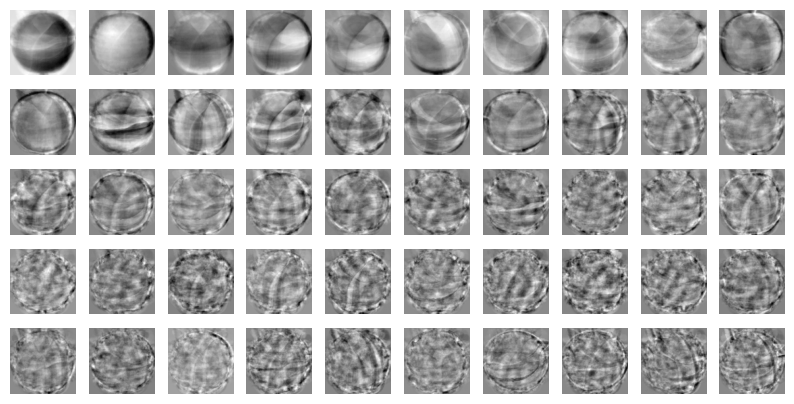

In [25]:
draw_fruits(pca.components_.reshape(-1,100,100))

In [27]:
print(fruits_2d.shape)

(300, 10000)


In [29]:
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 50)


## 원본데이터 재구성

10000개의 특성을 50개로 줄였으므로 손실이 발생할 수 밖에 없다.
그러나 최대한 분산이 큰 방향으로 데이터를 투영했기 때문에 원본데이터를 상당 부분 재구성 할 수 있다.

PCA 클래스는 이를 위해 inverse_transform() 메서드를 제공한다.

In [32]:
fruits_inverse = pca.inverse_transform(fruits_pca)
print(fruits_inverse.shape)

(300, 10000)


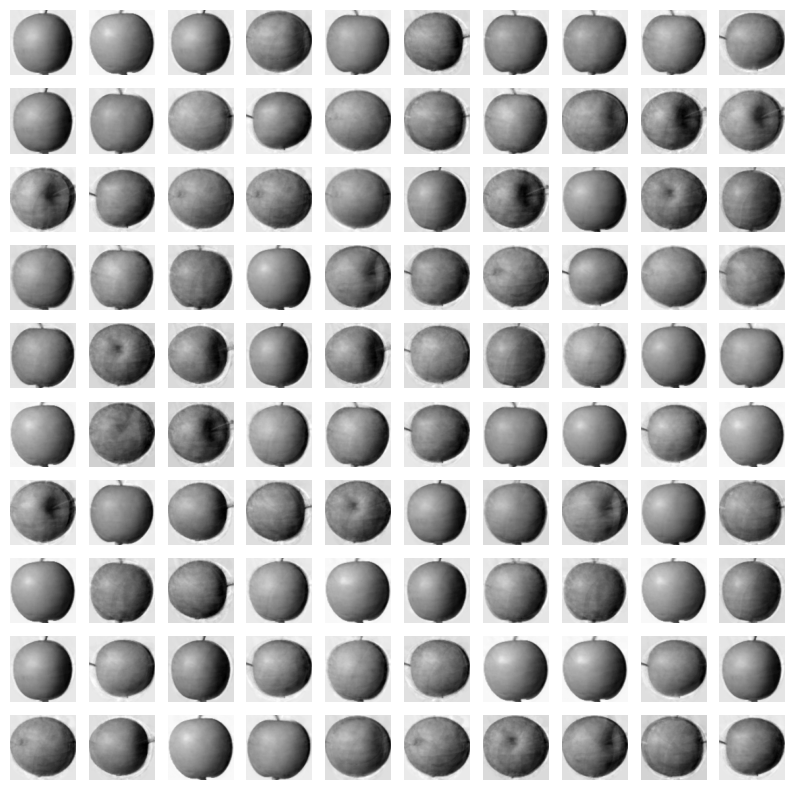

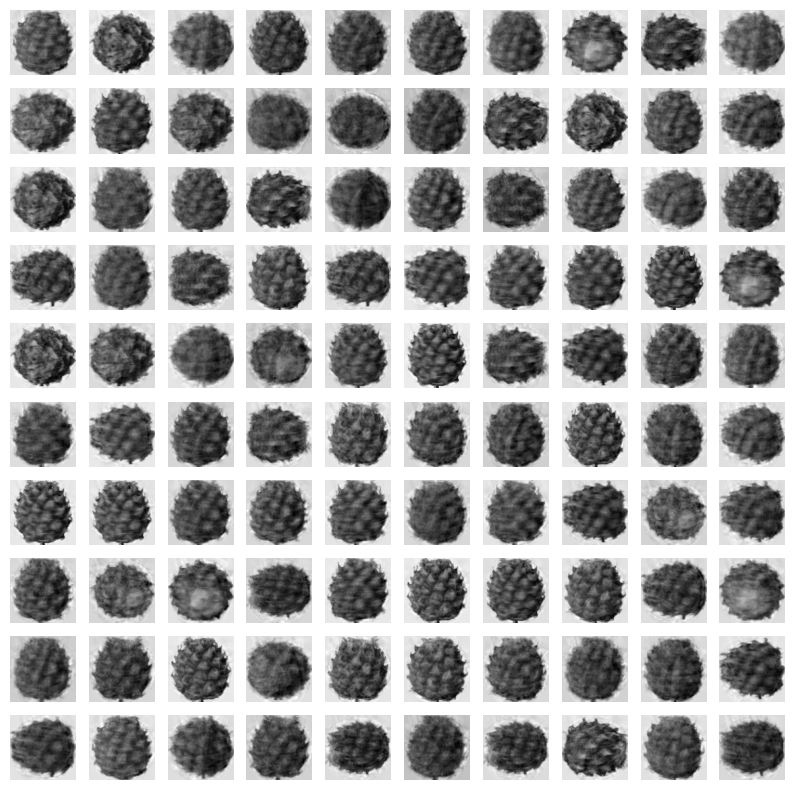

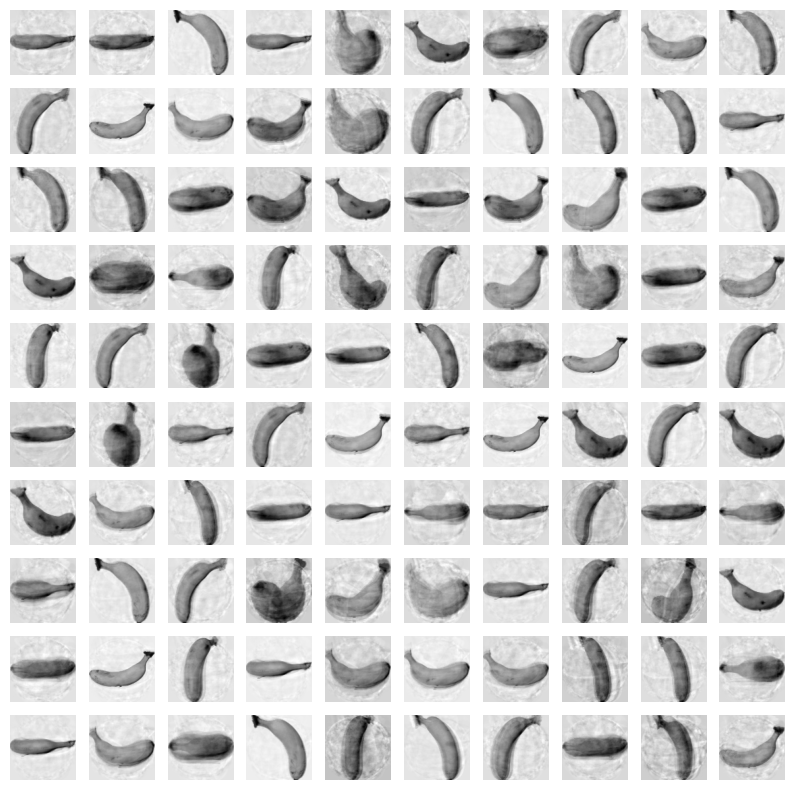

In [36]:
fruits_reconstruct = fruits_inverse.reshape(-1, 100, 100)
for start in [0,100,200]:
    draw_fruits(fruits_reconstruct[start:start+100])
    print("\n")

## 설명된 분산

주성분이 원본 데이터의 분산을 얼마나 잘 나타내는지를 기록한 값을 **설명된 분산(explained variance)** 이라고 한다.

PCA 클래스의 explained_variance_ratio_ 에 각 주성분의 설명된 분산 비율이 기록되며, 당연히 첫번째 주성분의 설명된 분산이 가장 크다. 주성분 분석을 할 때 분산이 큰 방향으로 축을 그리기 때문이다.

explained_variance_ratio_에 기록된 분산 비율을 모두 더하면 50개의 주성분으로 표현하고 있는 총 분산 비율을 얻을 수 있다.

In [41]:
print(np.sum(pca.explained_variance_ratio_))

0.9214977023655482


92%가 넘는 분산을 유지하고 있기 때문에 복원을 했을때에도 이미지의 품질이 높았던 것이다.

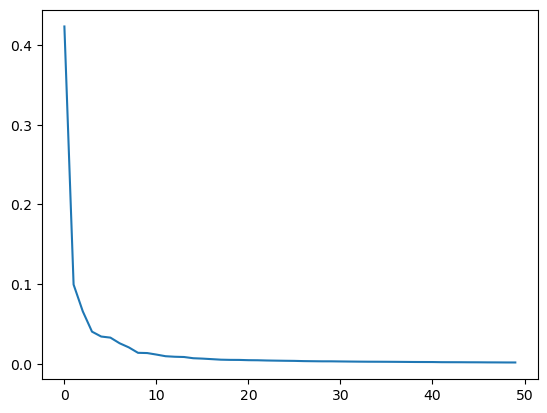

In [44]:
plt.plot(pca.explained_variance_ratio_)
plt.show()

그래프에서 첫 10개의 주성분이 대부분의 분산을 표현하고 있으며, 그 다음 값들이 설명하는 분산 비율을 비교적 작다.

### 다른 알고리즘과 함께 사용해보기

PCA로 축소한 데이터를 가지고 로지스틱 회귀모델을 구현해보자

In [48]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [50]:
# 사과를 0, 파인애플을 1, 바나나를 2로 하여 label 할당(지도학습)
target = np.array([0]*100 + [1]*100 + [2]*100)

In [54]:
from sklearn.model_selection import cross_validate
# PCA사용 이전 데이터 
scores = cross_validate(lr, fruits_2d, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.9966666666666667
0.2460028648376465


In [56]:
# PCA사용 이후 데이터 
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.9966666666666667
0.02428412437438965


50개의 특성만을 사용하였는데도 정확도는 높고, 훈련시간은 0.02초로 훨씬 단축되었다.

PCA로 훈련데이터의 차원을 축소하면 메모리용량 뿐만아니라 훈련속도도 높일 수 있다.

In [61]:
# n_components를 0~1사이의 실수로 입력하면 원하는 설명된 분산의 비율에 도달할 때 까지 자동으로 주성분을 찾는다.
# 설명된 분산의 50%에 달하는 주성분을 찾도록 PCA모델을 만들어 보자.
pca = PCA(n_components=0.5)
pca.fit(fruits_2d)

PCA(n_components=0.5)

In [65]:
print(pca.n_components_)

2


단 2개의 특성으로 전체 분산의 50%를 표현할 수 있다.

In [68]:
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 2)


In [72]:
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.99
0.05928497314453125


C:\Users\kdm12\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


*위의 경고메시지는 로지스틱 회구 모델이 완전히 수렴하지 못했으니 반복횟수를 증가시키라는 메시지이나, 교차검증의 결과가 좋으니 무시해도 된다*

In [77]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=42)
km.fit(fruits_pca)
print(np.unique(km.labels_, return_counts=True))

C:\Users\kdm12\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\kdm12\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\kdm12\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kdm12\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\kdm12\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
 

(array([0, 1, 2]), array([110,  99,  91], dtype=int64))


C:\Users\kdm12\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


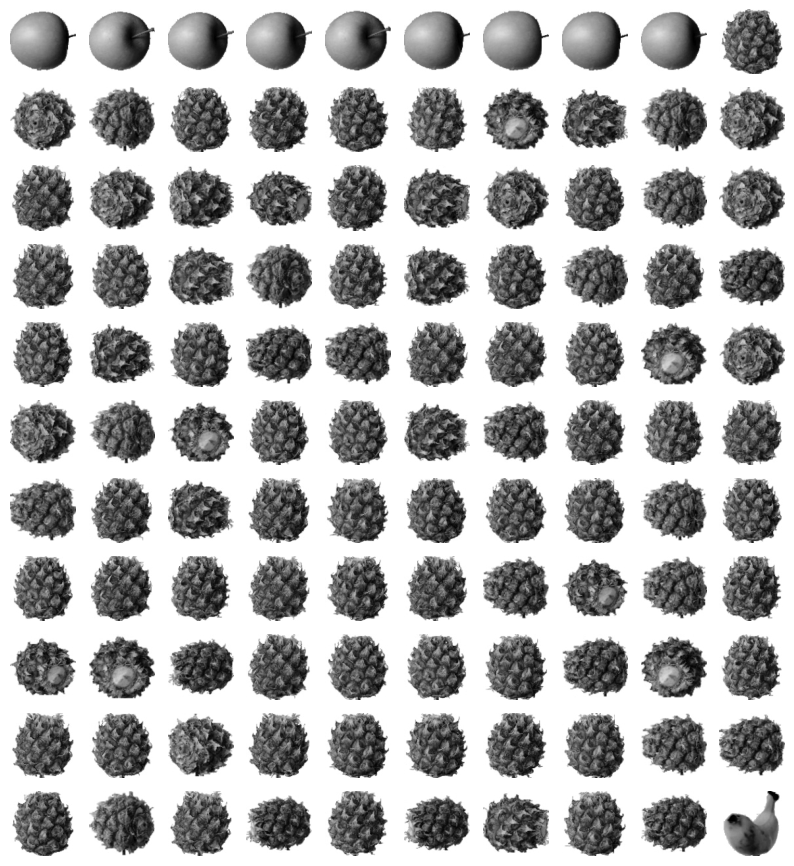

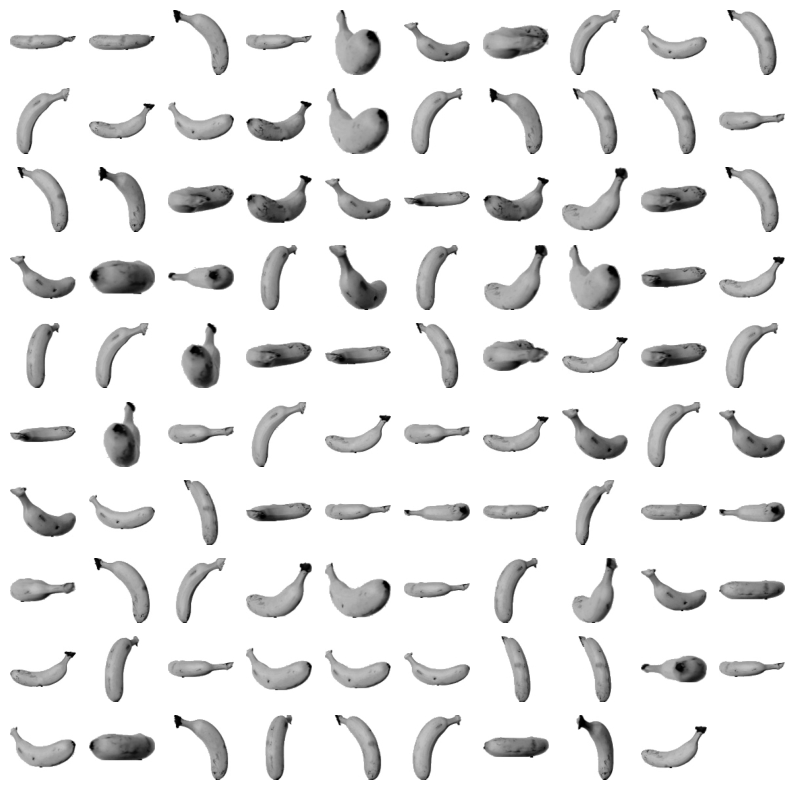

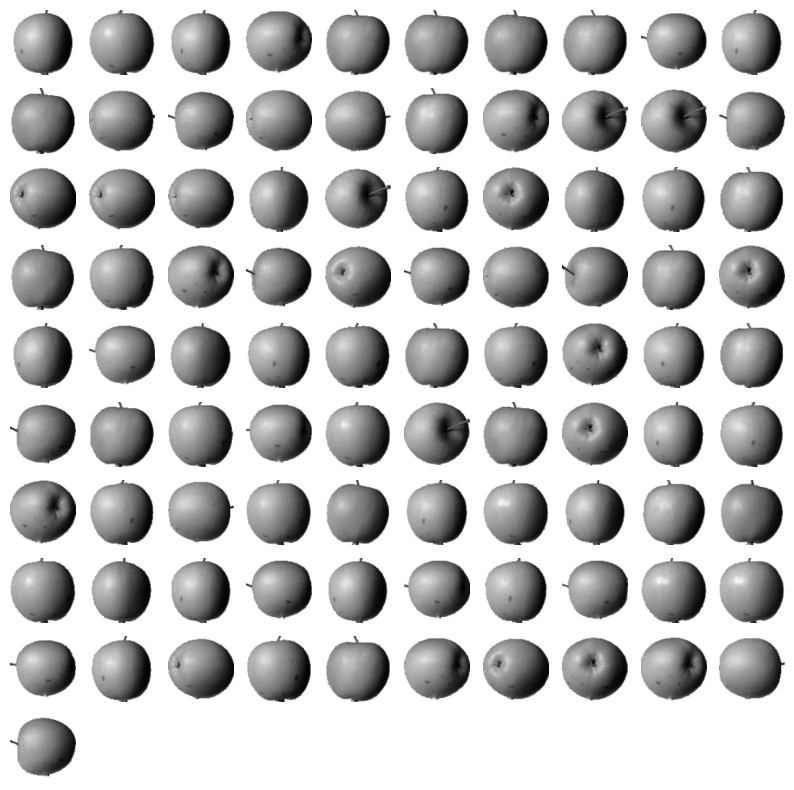

In [79]:
for label in range(0,3):
    draw_fruits(fruits[km.labels_ == label])
    print("\n")

PCA로 차원을 2개로 줄였기에 그래프에 시각화를 하면 직관적인 이해를 도울 수 있다.

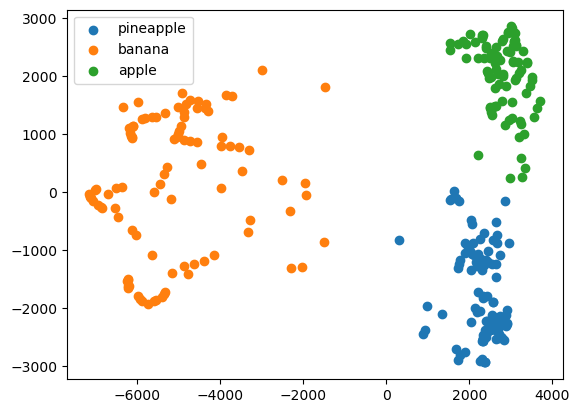

In [89]:
for label in range(0,3):
    data = fruits_pca[km.labels_ == label]
    plt.scatter(data[:,0], data[:,1])
plt.legend(['pineapple','banana','apple'])
plt.show()

그림에서 사과와 파인애플의 클러스터 경계가 가까이 붙어있어 사과를 파인애플로 오인한 결과가 나타났다고 예상해볼 수 있다.